# Adjusting Pore Size Distributions

In [1]:
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst


Start by creating a standard cubic lattice topology.  Note that no pore or throat sizes are given yet, only the spacing between the lattice cells.  This spacing dictates the upper limit of pore sizes, since we don't generally want pores that exceed their cells and overlap their neighbors.  This causes geometrical paradoxes like negative throat lengths.  Here we'll use a large spacing so that the pore sizes do not need to be expressed in scientific notation below.

In [2]:
pn = op.network.Cubic(shape=[25, 25, 1], spacing=1)

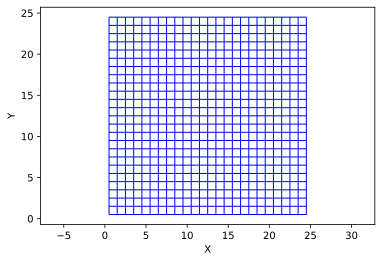

In [3]:
fig = op.topotools.plot_connections(network=pn)
_ = plt.axis('equal')

We'll also create an *empty* geometry object where we'll store the pore and throat sizes.  

> At the risk of confusing things, this information can also be stored on the network but it's good practice to divide the infomation onto the correct objects for when your simulations get more complicated.

In [4]:
geo = op.geometry.GenericGeometry(network=pn, pores=pn.Ps, throats=pn.Ts)

## Generating pore size distributions

Now that we have a network, we can assign pore sizes.  This *can* be done manually but generating numbers from any of the distributions in ``scipy.stats``, but OpenPNM has several predefined **pore-scale** models for this purpose. The follow code block will illustrate boths, although the latter is preferred.

### Using scipy.stats classes directly

Let's start by fetching a statistical *class* from the ``scipy.stats`` module, in this case the ``weibull_min``:

In [5]:
f = spst.weibull_min

This class has *many* methods available. These can inspected by typing ``f.`` the pressing ``tab`` to show a list. Below we'll print them all (only the public ones that don't start with an underscore):

In [6]:
for m in f.__dir__():
    if not m.startswith('_'):
        print(m)

badvalue
name
a
b
xtol
moment_type
shapes
extradoc
numargs
vecentropy
generic_moment
pdf
logpdf
cdf
logcdf
sf
logsf
ppf
isf
nnlf
fit
fit_loc_scale
expect
random_state
freeze
rvs
stats
entropy
moment
median
mean
var
std
interval
support


For this demo we want to generate a list of numbers from the distribution, which is accomplished using the ``rvs`` method, as follows:

In [7]:
x = f.rvs(c=2, loc=0, scale=.4, size=pn.Np, random_state=None)

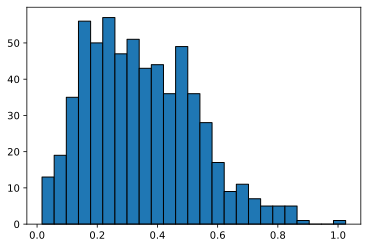

In [8]:
fig = plt.hist(x, bins=25, edgecolor='k')

Note that for the ``size`` of the array we put the number of pores on the network, so that we can assign one value to each pore as follows:

In [9]:
geo['pore.diameter'] = x

### Using pre-defined pore-scale models in OpenPNM

The advantage of using the built-in models from OpenPNM is that (a) you can regenerate the distribution programmatically (``geom.regenerate_models``), (b) you can save the project to file and the model information will be retained, and (c) you can change parameters on the model to parametric studies very easily.

For this demo we'll remove the values created above, and start fresh:

In [10]:
del geo['pore.diameter']

OpenPNM use a 'reverse look-up' to get pores sizes, meaning you put a random number between 0 and 1 in each pore, then do a reverse look-up on the cumulative probability curve to find the corresponding size.  The allows users to generate their own random numbers, for instance using spatial correlations, then assign sizes. 

In [11]:
f = op.models.geometry.pore_seed.random
geo.add_model(propname='pore.seed',
              model=f, num_range=[0.0, 0.99])

The ``num_range`` was set set to prevent the generation of excessively large pores from far out  on the long tail of the distribution.

In [12]:
f = op.models.geometry.pore_size.weibull
geo.add_model(propname='pore.diameter',
              model=f, shape=2, scale=0.4, loc=0)

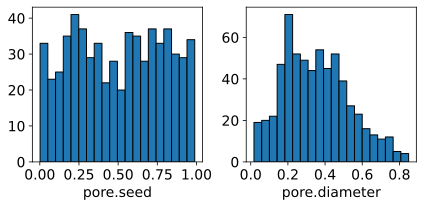

In [13]:
geo.show_hist(['pore.seed', 'pore.diameter'])

If for some reason we were unhappy with the distribution, it can easily be changed and updated.  For instance, to reduce the number of small pores, we can adjust the ``num_range`` parameter on the ``'pore.seed'`` model and re-run:

In [14]:
geo.models['pore.seed']['num_range'] = [0.25, 0.99]
geo.regenerate_models()

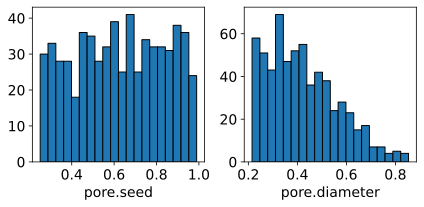

In [15]:
geo.show_hist(['pore.seed', 'pore.diameter'])

This illustrates the power/utility of using pore-scale models properly, instead of essentially hard-coding the pore size values as was done by using the ``scipy.stats`` classes directly.

Ideally this should be viewed in Paraview, but a quick plot with ``plot_networkx`` shows the pore sizes.

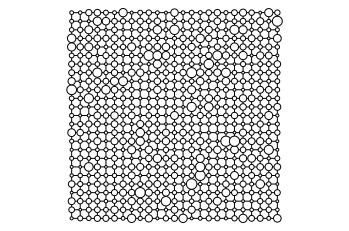

In [16]:
ig = op.topotools.plot_networkx(pn, scale=1.5)

## Adding throat sizes

Now that we've settled on pores sizes, we can assign throat sizes.  The throats should always be less than or equal to the size of the two pores they connect...otherwise they're not really throats.  

> OpenPNM will not break if this happens, but you'd need to check the consistency of the results very carefully.

To ensure the thoats are always smaller than their connected pores, OpenPNM provides pore-scale model called ``from_neighbor_pores``.  This can be used to either (a) fetch the minimum pore size adopt that (and maybe also scale that value down), or (b) fetch the seed values from the pores and use that in a distinct distribution.  Let's do both, in order:

In [17]:
f = op.models.misc.from_neighbor_pores
geo.add_model(propname='throat.diameter_1',
              model=f, prop='pore.diameter', mode='min')

In [18]:
f = op.models.misc.from_neighbor_pores
geo.add_model(propname='throat.seed',
              model=f, prop='pore.seed', mode='min')
f = op.models.geometry.throat_size.weibull
geo.add_model(propname='throat.diameter_2',
              model=f, shape=1.5, scale=.2, loc=0)

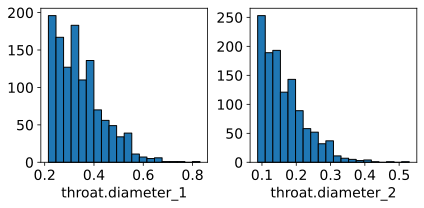

In [19]:
geo.show_hist(['throat.diameter_1', 'throat.diameter_2'])

Note that in the second approach the Weibull parameters were carefuly chosen to ensure a smaller distribution than the pore sizes, for reasons of geometrical consistency mentioned above.